In [17]:
import os
import json
import re
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from dataclasses import dataclass
from scipy.stats import pearsonr
def parse_jsonl(data):
    parsed_data = []
    for line in data:
        parsed_data.append(json.loads(line))

    return parsed_data

def get_main_df(path, file_in_question):

    main_df = pd.DataFrame()
    for root, dirs, files in os.walk(path):
        if "layer" not in root:
            continue

        for file in files:

            if file == file_in_question:
                with open(os.path.join(root, file)) as f:
                    data = f.readlines()


                parsed_data = parse_jsonl(data)
                df = pd.DataFrame(parsed_data)
                
                # We have tp, fp, tn, fn
                # We want precision, recall, f1
                df["precision"] = df["tp"] / (df["tp"] + df["fp"])
                df["recall"] = df["tp"] / (df["tp"] + df["fn"])
                df["f1"] = 2 * (df["precision"] * df["recall"]) / (df["precision"] + df["recall"])
                df["accuracy"] = (df["tp"] + df["tn"]) / (df["tp"] + df["tn"] + df["fp"] + df["fn"])
                df["layer"] = re.search(r"layer(\d+)", root).group(1)

                main_df = pd.concat([main_df, df])

    # reset index
    main_df = main_df.reset_index(drop=True)
    return main_df

def get_best(main_df, specific_layer:int=None):
    if specific_layer is not None:
        print(f"Filtering for layer {specific_layer}")
        main_df = main_df[main_df["layer"] == str(specific_layer)]
    best_accuracy = main_df[main_df["accuracy"] == main_df["accuracy"].max()]["accuracy"]
    best_f1 = main_df[main_df["f1"] == main_df["f1"].max()]["f1"]
    layer = main_df[main_df["f1"] == main_df["f1"].max()]["layer"]
    print(f"Best layer: {layer.values[0]}")
    print(main_df[main_df["f1"] == main_df["f1"].max()].head(1))
    sorted_df = main_df.sort_values(by=["f1"], ascending=False)
    return best_accuracy, best_f1, sorted_df


# Define Metric structure
@dataclass
class Metric:
    name: str
    label: str


def get_correlation(main_df, 
                    x_col:str="n_features",
                    y_col:str="f1"):
    # Compute correlation
    correlation, p_value = pearsonr(main_df[x_col], main_df[y_col])
    return correlation, p_value

Best layer: 11
       classifier  n_features  tp  fp  tn  fn  \
22  random_forest          20  25   6  24   5   

                                               y_pred  \
22  [0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, ...   

                                               y_test  \
22  [0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, ...   

                                          best_params  \
22  {'max_depth': None, 'max_features': 'sqrt', 'm...   

                    dataset  precision    recall        f1  accuracy layer  
22  gpt2_gbug-java/layer11/   0.806452  0.833333  0.819672  0.816667    11  
For random_forest.jsonl in gpt2_gbug-java
BEST F1: 22    0.819672
Name: f1, dtype: float64
Best layer: 4
        classifier  n_features  tp  fp  tn  fn  \
340  random_forest           5  72  23  72  23   

                                                y_pred  \
340  [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, ...   

                                                y_test  \
340  [

/var/folders/b4/lwfgccm95kqd2skcwvrt2fr00000gn/T/ipykernel_21270/3903608650.py:71: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(
/var/folders/b4/lwfgccm95kqd2skcwvrt2fr00000gn/T/ipykernel_21270/3903608650.py:71: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(
/var/folders/b4/lwfgccm95kqd2skcwvrt2fr00000gn/T/ipykernel_21270/3903608650.py:71: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(


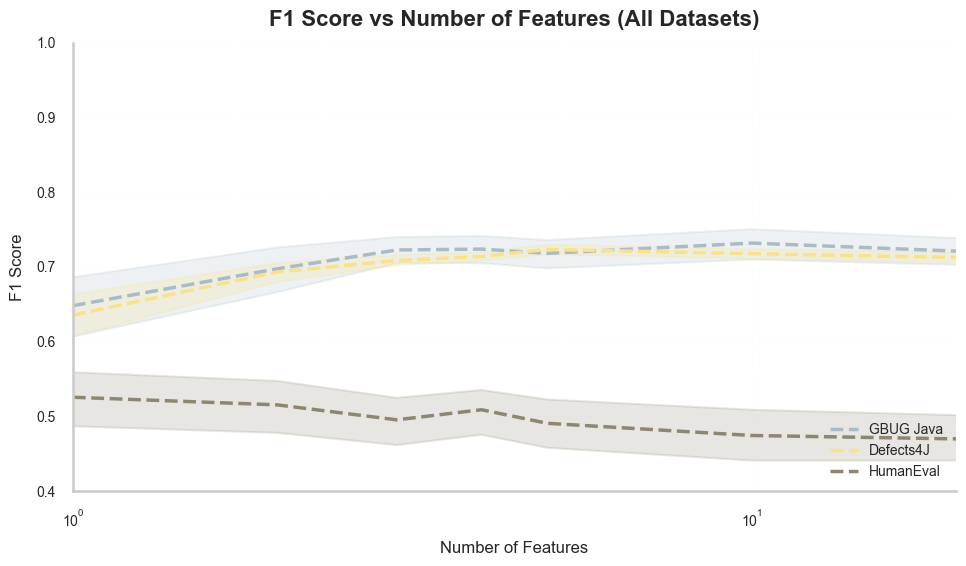

In [19]:
# Available metrics
F1 = Metric("f1", "F1 Score")
ACCURACY = Metric("accuracy", "Accuracy")
ACTIVE_METRIC = F1

@dataclass
class Model_topK_datasets:
    dataset_gbug_java_path: str
    dataset_defects4j_path: str
    dataset_humaneval_path: str


GPT2_ = Model_topK_datasets(
    dataset_gbug_java_path="gpt2_gbug-java",
    dataset_defects4j_path="gpt2_defects4j",
    dataset_humaneval_path="gpt2_humaneval"
)
# List of models/datasets
models = {
    "gpt2_gbug-java": GPT2_.dataset_gbug_java_path,
    "gpt2_defects4j": GPT2_.dataset_defects4j_path,
    "gpt2_humaneval": GPT2_.dataset_humaneval_path
}


file_in_question = "random_forest.jsonl"

# Custom color palette inspired by the diagram
colors = {
    "gbug": "#d3dee3",         # Soft Blue-Grey
    "defects": "#fdf3d1",      # Light Yellow
    "humaneval": "#b8b09c"     # Neutral Grey
}
colors = {
    "gbug": "#a9bcc5",         # Slightly darker blue-grey
    "defects": "#f9e28b",      # Richer yellow
    "humaneval": "#8f8671"     # Deeper neutral
}
fig, ax = plt.subplots(figsize=(10, 6))

# Set Seaborn aesthetic theme
sns.set_theme(style="whitegrid", context="talk")

for label, path in models.items():
    main_df = get_main_df(path, file_in_question)
    # # Filter for specific layer if needed
    # main_df = main_df[main_df["layer"] == "0"]
    main_df = main_df[main_df["n_features"] <= 100]
    

    best_accuracy, best_f1, best_result = get_best(main_df)

    print(f"For {file_in_question} in {path}")
    print(f"BEST F1: {best_f1}")

    # Extract dataset key for color mapping
    if "gbug" in label:
        color = colors["gbug"]
        display_label = "GBUG Java"
    elif "defects" in label:
        color = colors["defects"]
        display_label = "Defects4J"
    elif "humaneval" in label:
        color = colors["humaneval"]
        display_label = "HumanEval"
    else:
        color = "#333333"
        display_label = label

    # Plot each dataset line on the same axis
    sns.lineplot(
        data=main_df,
        x="n_features",
        y=ACTIVE_METRIC.name,
        ci=95,
        label=display_label,
        color=color,
        linewidth=2.5,
        linestyle="--",
        ax=ax
    )

# Title and labels for shared plot
ax.set_title(
    f"{ACTIVE_METRIC.label} vs Number of Features (All Datasets)",
    fontsize=16,
    fontweight="bold",
    pad=12
)
ax.set_xlabel("Number of Features", fontsize=12, labelpad=8)
ax.set_ylabel(ACTIVE_METRIC.label, fontsize=12, labelpad=8)

# Log scale x-axis
ax.set_xscale("log")
ax.set_xlim(1, 20)
ax.set_ylim(0.4, 1)

# Ticks and style
ax.tick_params(labelsize=10)
ax.grid(True, which="major", linestyle=":", linewidth=0.7, alpha=0.1)
ax.legend(fontsize=10, loc="lower right", frameon=False)
sns.despine(ax=ax)

plt.tight_layout()
plt.show()


In [3]:

for label, path in models.items():
    main_df = get_main_df(path, file_in_question)
    print(get_correlation(main_df, x_col="n_features", y_col=ACTIVE_METRIC.name,
                    max_n_features=20))


(np.float64(0.17226054756259013), np.float64(0.014722936161279806))
(np.float64(0.2768239213460738), np.float64(0.000280678858743036))
(np.float64(-0.265627568254292), np.float64(0.01460285129826854))


/var/folders/b4/lwfgccm95kqd2skcwvrt2fr00000gn/T/ipykernel_21270/1215918533.py:59: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(
/var/folders/b4/lwfgccm95kqd2skcwvrt2fr00000gn/T/ipykernel_21270/1215918533.py:59: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(
/var/folders/b4/lwfgccm95kqd2skcwvrt2fr00000gn/T/ipykernel_21270/1215918533.py:59: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(


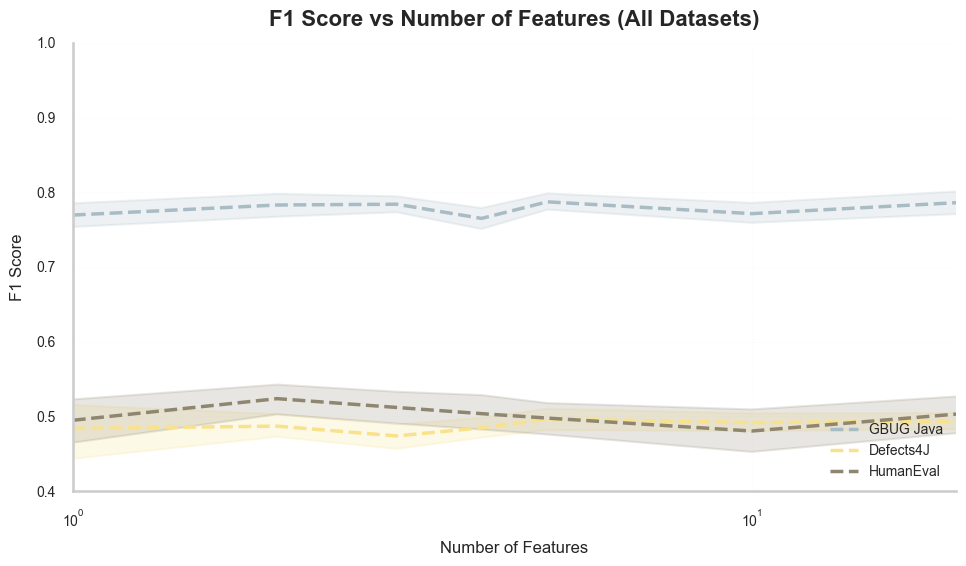

In [4]:


GPT2_ = Model_topK_datasets(
    dataset_gbug_java_path="gemma2_gbug-java",
    dataset_defects4j_path="gemma2_defects4j",
    dataset_humaneval_path="gemma2_humaneval"
)
# List of models/datasets
models = {
    "gemma2_gbug-java": GPT2_.dataset_gbug_java_path,
    "gemma2_defects4j": GPT2_.dataset_defects4j_path,
    "gemma2_humaneval": GPT2_.dataset_humaneval_path
}


file_in_question = "random_forest.jsonl"

# Custom color palette inspired by the diagram
colors = {
    "gbug": "#d3dee3",         # Soft Blue-Grey
    "defects": "#fdf3d1",      # Light Yellow
    "humaneval": "#b8b09c"     # Neutral Grey
}
colors = {
    "gbug": "#a9bcc5",         # Slightly darker blue-grey
    "defects": "#f9e28b",      # Richer yellow
    "humaneval": "#8f8671"     # Deeper neutral
}
fig, ax = plt.subplots(figsize=(10, 6))

# Set Seaborn aesthetic theme
sns.set_theme(style="whitegrid", context="talk")

for label, path in models.items():
    
    main_df = get_main_df(path, file_in_question)
    
    # best_accuracy, best_f1, best_result = get_best(main_df, specific_layer=1)

    # print(f"For {file_in_question} in {path}")
    # print(f"BEST F1: {best_f1}")
    # print(f"BEST ACCURACY: {best_accuracy}")

    # Extract dataset key for color mapping
    if "gbug" in label:
        color = colors["gbug"]
        display_label = "GBUG Java"
    elif "defects" in label:
        color = colors["defects"]
        display_label = "Defects4J"
    elif "humaneval" in label:
        color = colors["humaneval"]
        display_label = "HumanEval"
    else:
        color = "#333333"
        display_label = label


    main_df[:1]
    # Plot each dataset line on the same axis
    sns.lineplot(
        data=main_df,
        x="n_features",
        y=ACTIVE_METRIC.name,
        ci=95,
        label=display_label,
        color=color,
        linewidth=2.5,
        linestyle="--",
        ax=ax
    )

# Title and labels for shared plot
ax.set_title(
    f"{ACTIVE_METRIC.label} vs Number of Features (All Datasets)",
    fontsize=16,
    fontweight="bold",
    pad=12
)
ax.set_xlabel("Number of Features", fontsize=12, labelpad=8)
ax.set_ylabel(ACTIVE_METRIC.label, fontsize=12, labelpad=8)

# Log scale x-axis
ax.set_xscale("log")
ax.set_xlim(1, 20)
ax.set_ylim(0.4, 1)

# Ticks and style
ax.tick_params(labelsize=10)
ax.grid(True, which="major", linestyle=":", linewidth=0.7, alpha=0.1)
ax.legend(fontsize=10, loc="lower right", frameon=False)
sns.despine(ax=ax)

plt.tight_layout()
plt.show()


In [ ]:
for label, path in models.items():
    main_df = get_main_df(path, file_in_question)
    print(get_correlation(main_df, x_col="n_features", y_col=ACTIVE_METRIC.name,
                    max_n_features=20))

(np.float64(0.07021848038829467), np.float64(0.36720519546389313))
(np.float64(nan), np.float64(nan))
(np.float64(-0.0580773946023129), np.float64(0.45459267285642274))
